In [2]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

AttributeError: module 'matplotlib' has no attribute 'get_data_path'

# 0. EDA

In [ ]:
data_path = Path("/home/gerard/PycharmProjects/epileptic-detection/data/")  #Path("./data/windows_data/chb01_raw_eeg_128_full.npz")
data = np.load(data_path / "windows_data" / "chb01_raw_eeg_128_full.npz")["arr_0"]
metadata = pd.read_csv(data_path / "metadata" / "chb01_raw_eeg_128_full.csv")

: 

In [54]:
data.shape, metadata.shape

((10740, 128, 21), (10740, 6))

In [43]:
metadata.head()

,id,label,pacient,index_inicial,periode,recording
0,0,0,1,0,0,0
1,1,0,1,128,0,0
2,2,0,1,256,0,0
3,3,0,1,384,0,0
4,4,0,1,512,0,0


### Label 0

In [55]:
sample_metadata = metadata[metadata["label"] == 0].sample()
sample_data = data[sample_metadata.id][0]

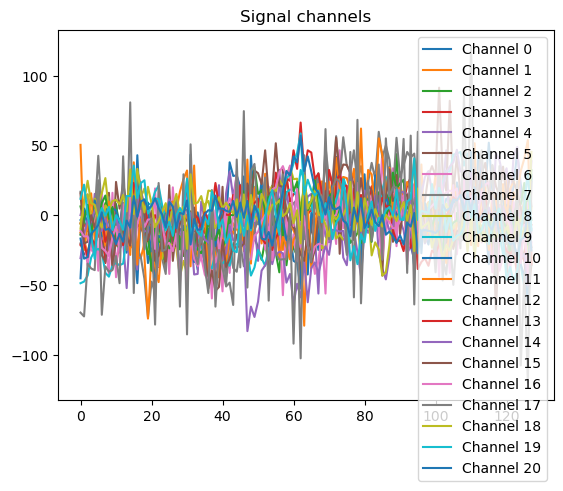

In [56]:
fig, ax = plt.subplots()
for i in range(sample_data.shape[-1]):
    ax.plot(sample_data[:, i], label=f"Channel {i}")

# Enable legend
ax.legend()
ax.set_title("Signal channels")
plt.show()

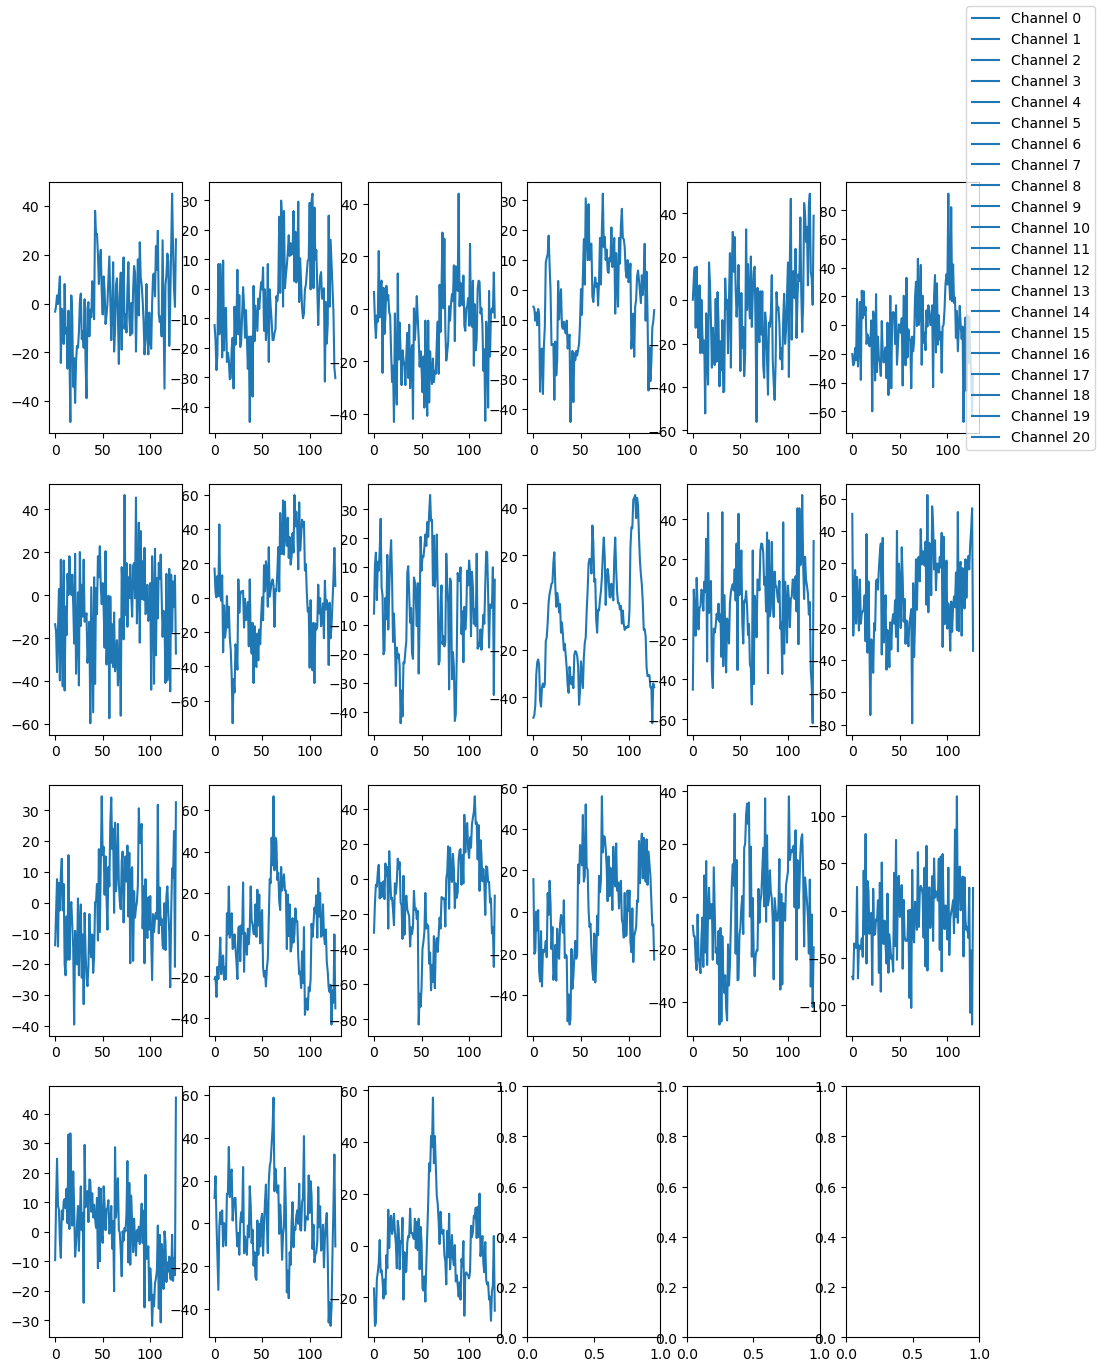

In [57]:
# Subplot: 4, 6
fig, ax = plt.subplots(4, 6, figsize=(12,15))
for i in range(sample_data.shape[-1]):
    ax[i//6, i%6].plot(sample_data[:, i], label=f"Channel {i}")

fig.legend(loc='upper right')
plt.show()

### Label 1

In [58]:
sample_metadata = metadata[metadata["label"] == 1].sample()
sample_data = data[sample_metadata.id][0]

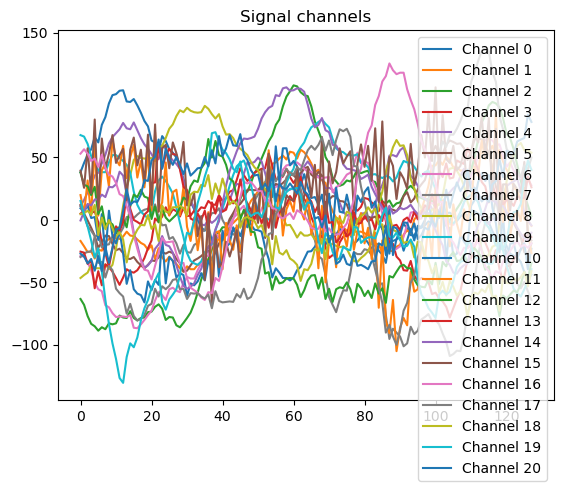

In [60]:
fig, ax = plt.subplots()
for i in range(sample_data.shape[-1]):
    ax.plot(sample_data[:, i], label=f"Channel {i}")

# Enable legend
ax.legend()
ax.set_title("Signal channels")
plt.show()

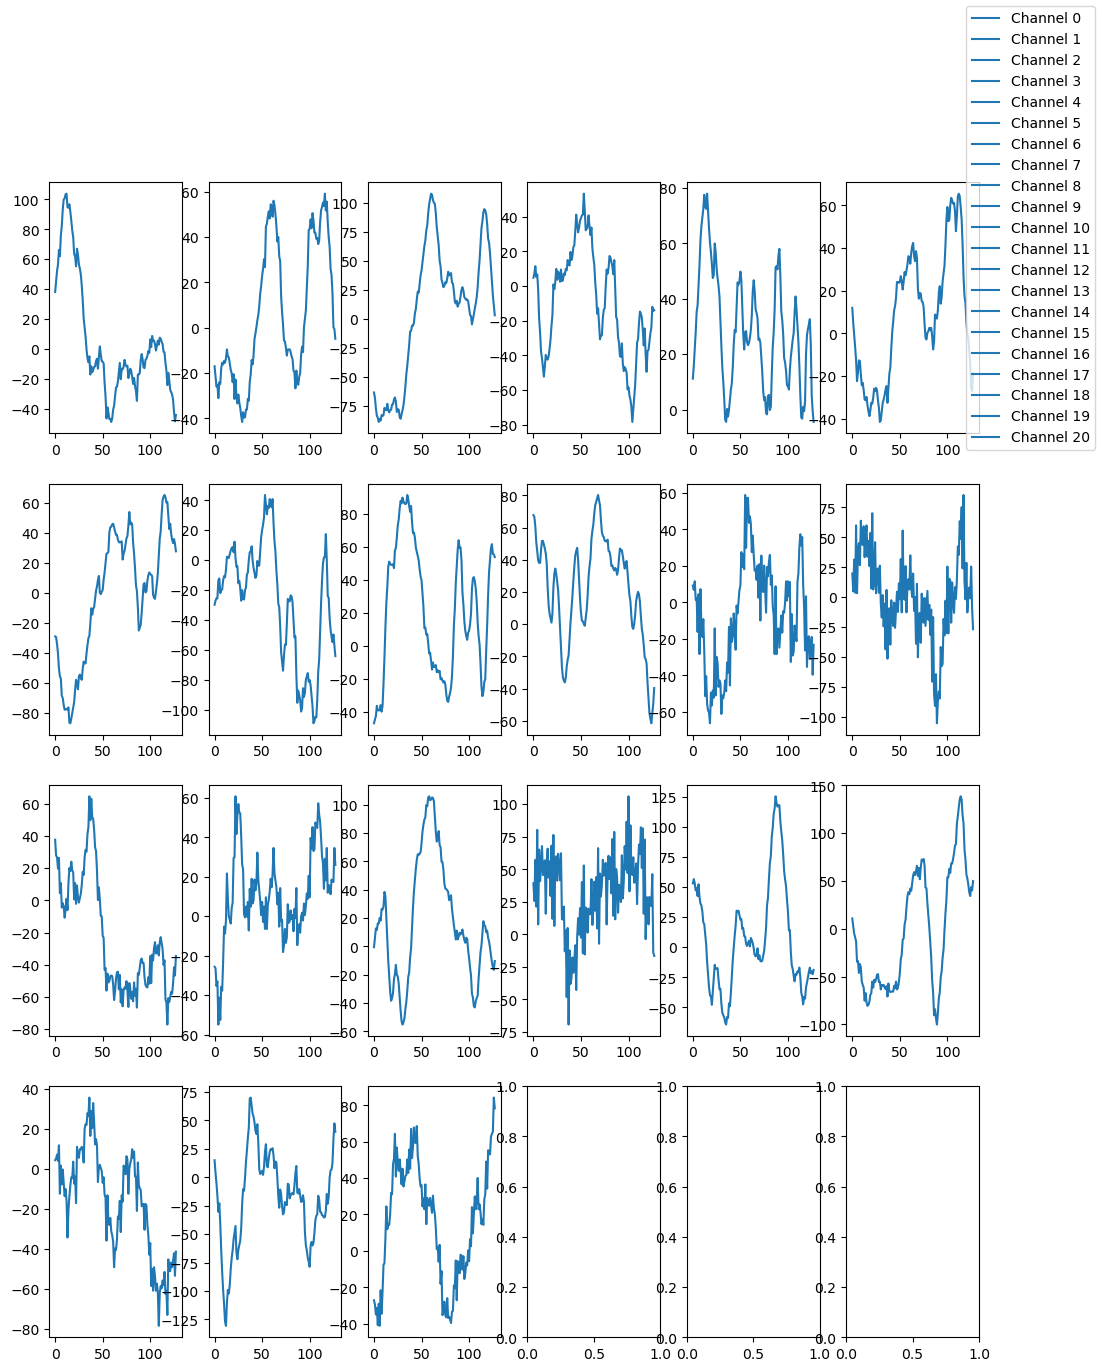

In [61]:
# Subplot: 4, 6
fig, ax = plt.subplots(4, 6, figsize=(12,15))
for i in range(sample_data.shape[-1]):
    ax[i//6, i%6].plot(sample_data[:, i], label=f"Channel {i}")

fig.legend(loc='upper right')
plt.show()

# 1. Dataset

In [31]:
from pathlib import Path
from typing import Union

import numpy as np
import pandas as pd
import torch
from PIL import Image
from torch.utils.data import Dataset

class EpilepticDataset(Dataset):

    def __init__(self, root_data_dir: Union[str, Path], metadata: pd.DataFrame, transforms=None):
        self.root_data_dir = Path(root_data_dir)
        self.data = self.load_data()
        self.metadata_df = metadata
        self.transforms = transforms

    def load_data(self) -> torch.Tensor:
        return torch.tensor(np.load(self.root_data_dir / "windows_data" / "chb01_raw_eeg_128_full.npz")["arr_0"], dtype=torch.float)

    def __len__(self):
        return len(self.metadata_df)

    def __getitem__(self, idx):
        metadata = self.metadata_df.iloc[idx]
        signal = self.data[idx]

        # Normalize to [0, 1]
        signal = (signal - signal.min()) / (signal.max() - signal.min())
        # Permute (w, c) -> (c, w)
        signal = signal.permute((1, 0))

        target = torch.tensor(metadata["label"], dtype=torch.long)  # Classes [0, 1]
        metadata = metadata[["id", "pacient", "index_inicial", "periode", "recording"]].to_dict()
        sample = {"signal": signal, "target": target, "metadata": metadata}

        if self.transforms:
            sample["signal"] = self.transforms(sample["signal"])

        return sample

In [32]:
root_data_dir = Path("../data/").resolve()
metadata = pd.read_csv(root_data_dir / "metadata" / "chb01_raw_eeg_128_full.csv")

ds = EpilepticDataset(root_data_dir, metadata)

In [33]:
ds[0]

{'signal': tensor([[0.6537, 0.4384, 0.4399,  ..., 0.4204, 0.4197, 0.4431],
         [0.5211, 0.4384, 0.4384,  ..., 0.4399, 0.4563, 0.4540],
         [0.3838, 0.4384, 0.4368,  ..., 0.4431, 0.4407, 0.4321],
         ...,
         [0.3924, 0.4384, 0.4337,  ..., 0.4275, 0.4306, 0.4025],
         [0.3370, 0.4384, 0.4407,  ..., 0.4704, 0.4618, 0.4399],
         [0.4134, 0.4384, 0.4384,  ..., 0.4399, 0.4259, 0.4540]]),
 'target': tensor(0),
 'metadata': {'id': 0,
  'pacient': 1,
  'index_inicial': 0,
  'periode': 0,
  'recording': 0}}

# 2. DataLoader

In [34]:
from pathlib import Path
from typing import Dict

import pandas as pd
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader

#from src.deep_learning.data.dataset import EpilepticDataset


class DataModule(pl.LightningDataModule):
    def __init__(self, root_data_dir: str = './data', batch_size: int = 32, num_workers: int = 4,
                 transforms: Dict = {"train": None, "valid": None, "test": None}):
        super().__init__()
        self.root_data_dir = Path(root_data_dir).resolve()
        self.batch_size = batch_size
        self.num_workers = num_workers

        self.dataset = EpilepticDataset
        self.transforms = transforms

    def setup(self, stage: str = None):
        if stage == 'fit' or stage is None:
            full_train_metadata_df = pd.read_csv(self.root_data_dir / "metadata" / "chb01_raw_eeg_128_full.csv")
            train_metadata_df, valid_metadata_df = train_test_split(full_train_metadata_df, test_size=0.2,
                                                                    random_state=0,
                                                                    stratify=full_train_metadata_df['label'])

            self.train_ds = self.dataset(self.root_data_dir, train_metadata_df, transforms=self.transforms["train"])
            self.valid_ds = self.dataset(self.root_data_dir, valid_metadata_df, transforms=self.transforms["valid"])

        if stage == 'test' or stage is None:
            # TODO test csv
            test_metadata_df = pd.read_csv(self.root_data_dir / "metadata" / "chb01_raw_eeg_128_full.csv")
            self.test_ds = self.dataset(self.root_data_dir, test_metadata_df, transforms=self.transforms["test"])

    def train_dataloader(self):
        return DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True, num_workers=self.num_workers)

    def val_dataloader(self):
        return DataLoader(self.valid_ds, batch_size=self.batch_size, num_workers=self.num_workers)

    def test_dataloader(self):
        return DataLoader(self.test_ds, batch_size=self.batch_size, num_workers=self.num_workers)


In [35]:
root_data_dir = Path("../data/").resolve()
dl = DataModule(root_data_dir, batch_size=4)
dl.setup()

In [36]:
next(iter(dl.train_dataloader()))

{'signal': tensor([[[0.6495, 0.6180, 0.5643,  ..., 0.4638, 0.4556, 0.4603],
          [0.5222, 0.5362, 0.5374,  ..., 0.6086, 0.5853, 0.4498],
          [0.7488, 0.7383, 0.6974,  ..., 0.4731, 0.4848, 0.5643],
          ...,
          [0.5935, 0.5584, 0.5467,  ..., 0.5152, 0.5491, 0.6741],
          [0.7629, 0.7956, 0.7804,  ..., 0.5339, 0.5502, 0.5701],
          [0.5199, 0.5315, 0.5164,  ..., 0.4650, 0.4591, 0.4696]],
 
         [[0.5577, 0.7642, 0.7212,  ..., 0.3236, 0.3167, 0.4079],
          [0.4888, 0.2685, 0.2978,  ..., 0.4406, 0.5060, 0.3649],
          [0.3460, 0.4303, 0.4286,  ..., 0.5749, 0.5009, 0.6024],
          ...,
          [0.5508, 0.5284, 0.5370,  ..., 0.4079, 0.4596, 0.4423],
          [0.3029, 0.2186, 0.2616,  ..., 0.3683, 0.2565, 0.4269],
          [0.2823, 0.5215, 0.8778,  ..., 0.3270, 0.3614, 0.3322]],
 
         [[0.4752, 0.3974, 0.5400,  ..., 0.5464, 0.3931, 0.4341],
          [0.3974, 0.6523, 0.4557,  ..., 0.2808, 0.5248, 0.4903],
          [0.7343, 0.5076, 0.6

# 3. Model (tsai)

In [47]:
from tsai.models.FCNPlus import FCNPlus

In [48]:
# Input: 24, Output: 2
FCNPlus(24, 2)

FCNPlus(
  (backbone): _FCNBlockPlus(
    (convblock1): ConvBlock(
      (0): Conv1d(24, 128, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock2): ConvBlock(
      (0): Conv1d(128, 256, kernel_size=(5,), stride=(1,), padding=(2,), bias=False)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (convblock3): ConvBlock(
      (0): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (add): Sequential()
  )
  (head): Sequential(
    (0): AdaptiveAvgPool1d(output_size=1)
    (1): Squeeze(dim=-1)
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
)

In [51]:
tsai_model = FCNPlus(24, 2)

# 4. LightningModule

In [52]:
import pytorch_lightning as pl
import torch.nn as nn
import torch.nn.functional as F
import torchmetrics


class LightningModule(pl.LightningModule):
    """Expects a tsai model as an input with a backbone and a head."""

    def __init__(self, model, num_classes=2, learning_rate=1e-2):
        super().__init__()

        # log hyperparameters
        self.save_hyperparameters()
        self.learning_rate = learning_rate

        self.num_classes = num_classes
        self.model = model

        self.loss = nn.BCELoss()
        self.accuracy = torchmetrics.Accuracy(num_classes=num_classes)

    def forward(self, x, metadata):
        x = self.model.backbone(x)
        x = self.model.head(x)
        # TODO softmax?
        return x

    def training_step(self, batch, batch_idx):
        images, target, metadata = batch["image"], batch["target"], batch["metadata"]
        logits = self.forward(images, metadata)
        loss = self.loss(logits, target)

        # training metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, target)
        f_score = self.f_score(preds, target)
        self.log('train_loss', loss, on_step=True, logger=True)
        self.log('train_acc', acc, on_epoch=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        images, target, metadata = batch["image"], batch["target"], batch["metadata"]
        logits = self.forward(images, metadata)
        loss = self.loss(logits, target)

        # validation metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, target)
        f_score = self.f_score(preds, target)
        self.log('val_loss', loss, on_step=True, logger=True)
        self.log('val_acc', acc, on_epoch=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        images, target, metadata = batch["image"], batch["target"], batch["metadata"]
        logits = self.forward(images, metadata)
        loss = self.loss(logits, target)

        # test metrics
        preds = torch.argmax(logits, dim=1)
        acc = self.accuracy(preds, target)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1, verbose=True)
        return {"optimizer": optimizer, "lr_scheduler": scheduler}

In [53]:
num_classes = 2
model = LightningModule(tsai_model, num_classes=num_classes, learning_rate=1e-3)

/home/gerard/miniconda3/envs/epileptic-detection/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:268: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


# 5. Logger - Wandb

# 6. Callbacks

# 7. Transforms

# 8. Trainer

In [ ]:
trainer = pl.Trainer(max_epochs=30,
                     gpus=1,
                     logger=wandb_logger,
                     callbacks=callbacks,
                     enable_progress_bar=True)

# 9. lr_find

In [54]:
def lr_find(trainer: pl.Trainer, model, dm: pl.LightningDataModule):
    # Run learning rate finder
    lr_finder = trainer.tuner.lr_find(model, dm)

    # Results can be found in
    print(lr_finder.results)

    # Plot with
    fig = lr_finder.plot(suggest=True)
    fig.show()
    fig.savefig("./lr_find.png")

    # Pick point based on plot, or get suggestion
    new_lr = lr_finder.suggestion()
    print(f"Using suggested lr: {new_lr}")

# 10. Train

In [ ]:
trainer.fit(model, dm)